In [2]:
# %pip install torch torchvision

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

Random Seed:  999


In [126]:
from typing import Optional
# Root directory for dataset
dataroot = "../resources/datasets/celeba/img_align_celeba"
generator_path = "./generator.pt"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Transform operations
transform = transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


def show_images(*images: Optional[torch.Tensor]):
  if len(images) > 1:
    _, axes = plt.subplots(1, len(images), figsize=(16, 8))
    for i, image in enumerate(images):
      grid = vutils.make_grid(image, padding=2, normalize=True)
      axes[i].imshow(np.transpose(grid.cpu().detach().numpy(), (1, 2, 0)))
  else:
    grid = vutils.make_grid(images[0], padding=2, normalize=True)
    plt.imshow(np.transpose(grid.cpu().detach().numpy(), (1, 2, 0)))
  plt.show()
  

In [4]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),
      # state size. ``(ngf*8) x 4 x 4``
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),
      # state size. ``(ngf*4) x 8 x 8``
      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      # state size. ``(ngf*2) x 16 x 16``
      nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      # state size. ``(ngf) x 32 x 32``
      nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
      nn.Tanh()
      # state size. ``(nc) x 64 x 64``
    )

  def forward(self, input):
    return self.main(input)

In [6]:
generator = Generator(ngpu)
generator.load_state_dict(torch.load(generator_path))
generator.eval()

generator.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [91]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd

img_name = lambda nr: f"{str(nr).zfill(6)}.jpg"

class CelebA(Dataset):
  def __init__(
      self, data_path, images_dir, num_files, img_transform=transforms.ToTensor(),
  ):
    self.data_path = data_path
    self.images_dir = images_dir
    self.img_transform = img_transform

    self.files_list = [
      img_name(nr) for nr in range(1, num_files + 1)
    ]

  def __len__(self):
    return len(self.files_list)

  def __getitem__(self, idx):
    filename = self.files_list[idx]
    img = Image.open(f"{self.data_path}/{self.images_dir}/{filename}").convert("RGB")

    if self.img_transform is not None:
      img = self.img_transform(img)

    return (img, filename)

TypeError: 'Axes' object is not subscriptable

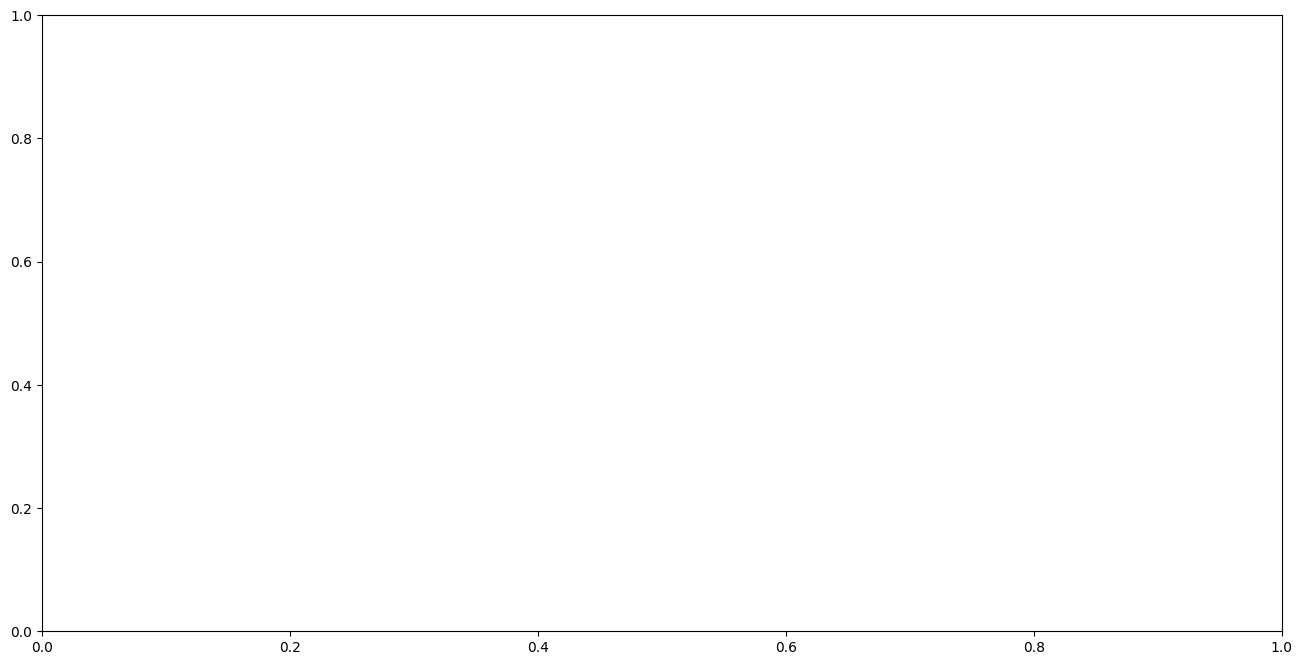

In [93]:
# show example image from dataset

dataset = CelebA(data_path='../resources/datasets/celeba', images_dir='img_align_celeba', num_files=5000, img_transform=transform)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=workers)
batch = next(iter(dataloader))

plt.imshow(
  np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0))
)


In [9]:
dataset = CelebA(data_path='../resources/datasets/celeba', images_dir='img_align_celeba', num_files=5000, img_transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=workers)

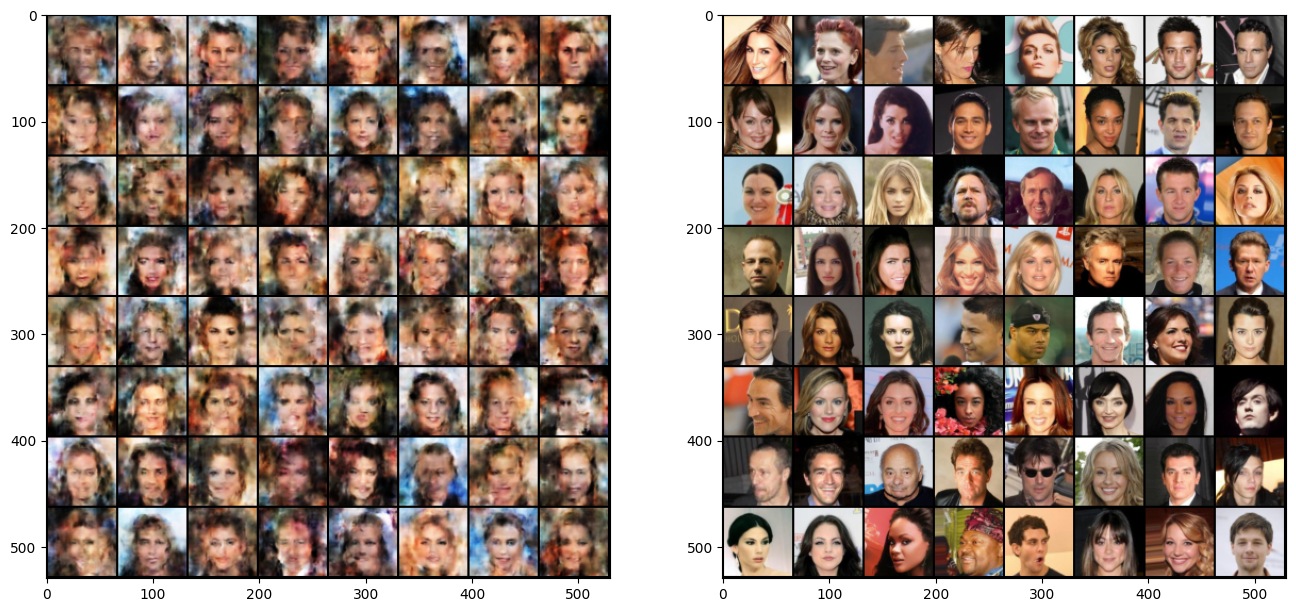

Batch 1/79: Step 0, Loss: 0.47034627199172974


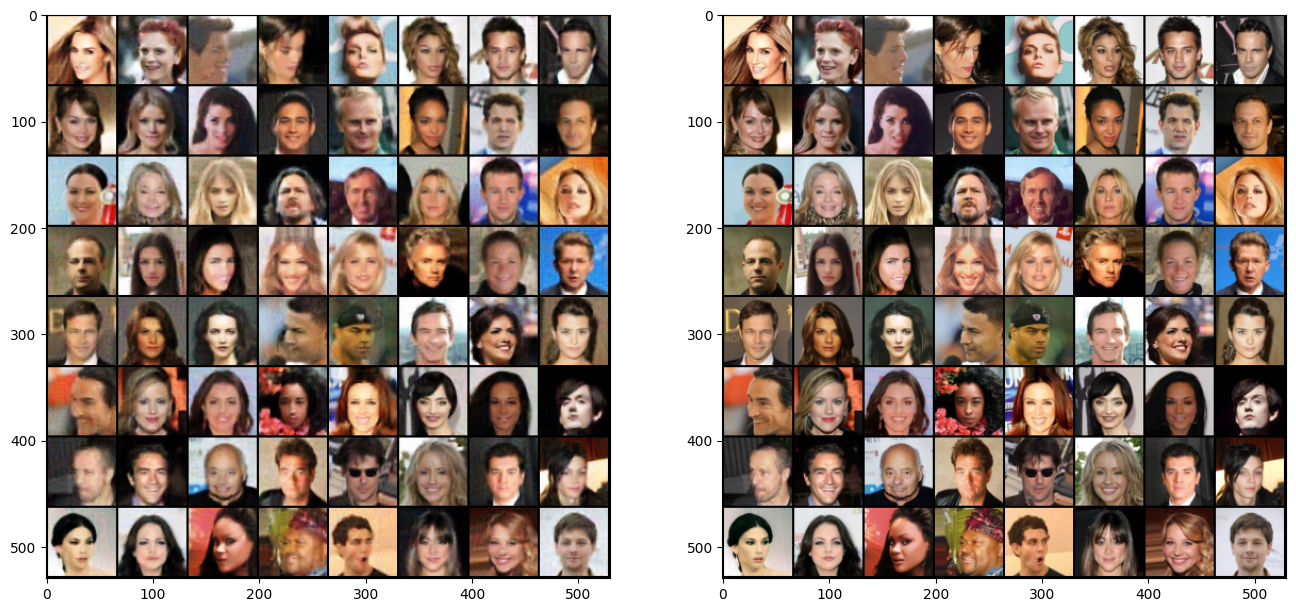

Batch 1/79: Step 500, Loss: 0.007496632635593414


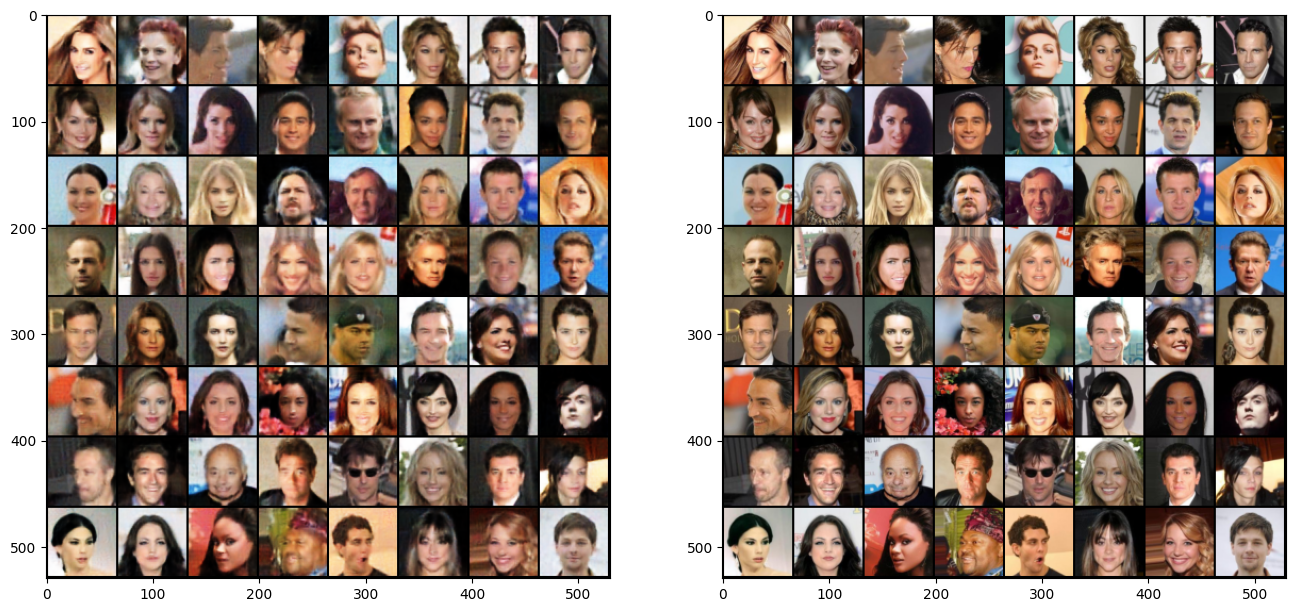

Batch 1/79: Step 1000, Loss: 0.00530689163133502


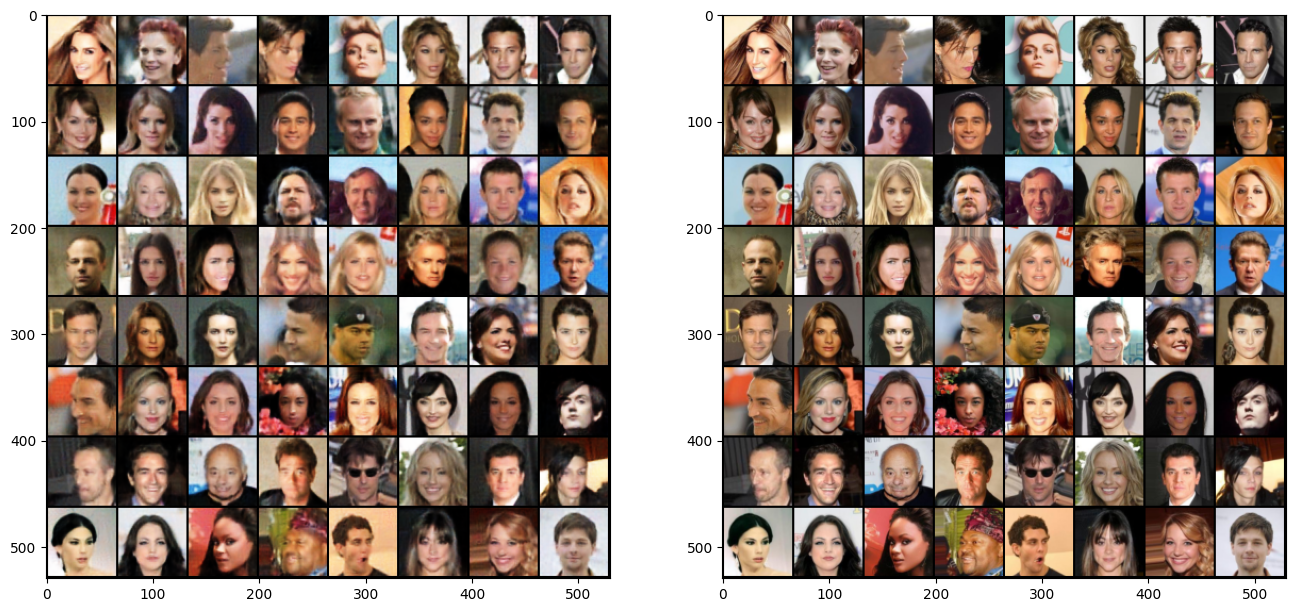

Batch 1/79: Step 1500, Loss: 0.004292139783501625


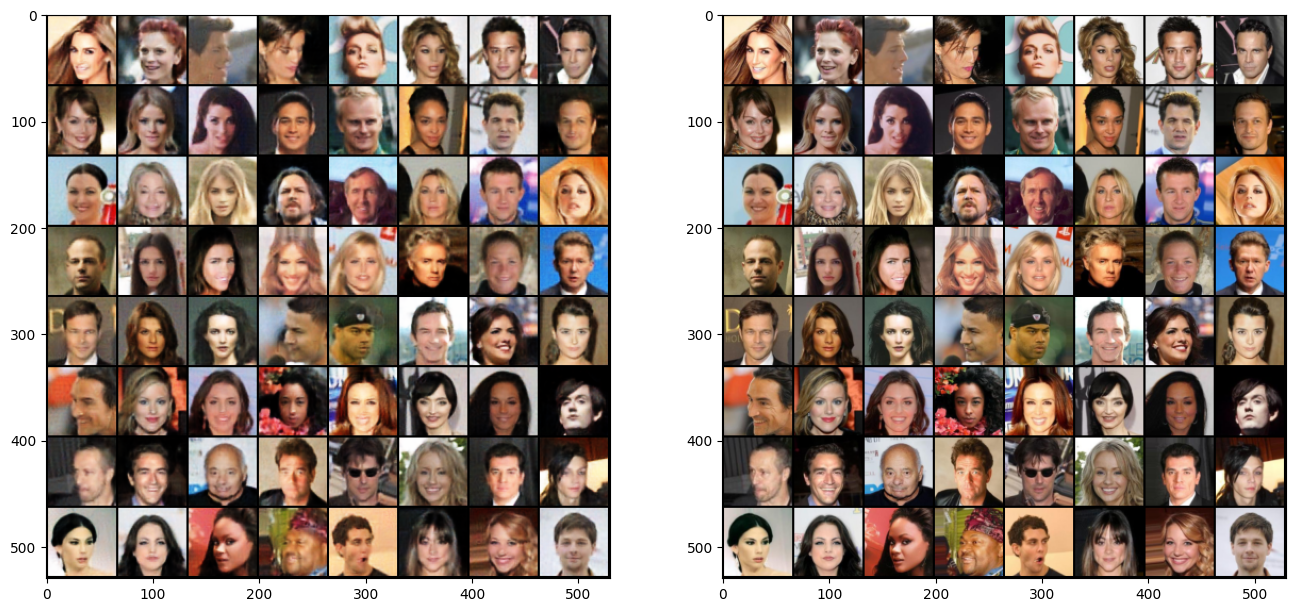

Batch 1/79: Step 2000, Loss: 0.003814935451373458


In [38]:
from torchvision.models import vgg16, VGG16_Weights
dataframe: pd.DataFrame = pd.DataFrame()


vgg = vgg16(weights=VGG16_Weights.DEFAULT).features.to(device).eval()
for param in vgg.parameters(): param.requires_grad = False

for batch_nr, (images, paths) in enumerate(dataloader, 1):
  images = images.to(device)

  b_size = images.size(0)
  latent_vector = torch.randn(b_size, nz, 1, 1, device=device, requires_grad=True)

  optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

  mse_criterion = nn.MSELoss()
  perceptual_criterion = nn.MSELoss()

  num_steps = 2000
  for step in range(num_steps + 1):
    optimizer.zero_grad()

    fake_images = generator(latent_vector)
    features = vgg(images).detach()
    fake_features = vgg(fake_images)

    perceptual_loss = perceptual_criterion(fake_features, features)
    mse_loss = mse_criterion(fake_images, images)
    loss = mse_loss + 0.03 * perceptual_loss

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if step % 500 == 0:
      show_images(fake_images, images)
      print(f"Batch {batch_nr}/{len(dataloader)}: Step {step}, Loss: {loss.item()}")

  image_rows = pd.DataFrame(latent_vector.squeeze().cpu().detach().numpy())
  image_rows['img'] = paths
  dataframe = pd.concat([dataframe, image_rows], ignore_index=True)


In [33]:
dataframe

0         1         2         3         4         5         6  \
0  -0.472191 -0.473776  0.069305 -0.212451  0.843403  0.318647 -0.927025   
1   0.020939  0.809271 -0.047104  0.819291  1.092139 -0.014050  0.781911   
2   1.561387  0.373351 -0.106039 -0.174281  0.341115  0.090234 -0.871496   
3   0.752416 -1.067337  0.370819 -0.219017 -1.755489 -1.161652  3.040377   
4  -1.229146  1.097034  0.364568 -0.140367  0.678441  0.744955  2.832391   
..       ...       ...       ...       ...       ...       ...       ...   
59  0.910634  0.784439 -0.059427 -0.812162  0.550757 -0.292456 -0.240784   
60 -0.852350  1.333607 -0.207241  0.110477 -1.723996 -2.599702 -0.446953   
61 -0.420955 -1.696878 -2.513355 -1.449852  0.341696 -2.223130 -0.009579   
62 -0.025535 -0.611704  1.052490  0.544867  1.197062 -1.389221  0.997005   
63  0.359193 -0.858536  0.513290  1.127377 -1.227126  0.916823  0.503609   

           7         8         9  ...        91        92        93        94  \
0   1.788725  0.209662 -1.128678  ... -0.085342  0.883523  0.250406 -1.723015   
1  -0.901892 -0.769017 -1.753215  ...  0.995541 -0.218991 -0.039927 -2.133431   
2  -2.514376 -1.095444 -0.466460  ... -0.459526 -0.067652 -0.274132  1.151575   
3   0.896041 -0.189104  0.500788  ...  0.665720  1.145859  1.300010 -0.017053   
4   0.040068  1.858201  0.804792  ...  2.143234 -1.095836  2.135337  1.070686   
..       ...       ...       ...  ...       ...       ...       ...       ...   
59 -0.529675  2.747226  1.680481  ... -0.216164  0.370482 -0.458606  0.719748   
60  0.410938 -0.467221 -0.643744  ...  0.712832 -0.761038  0.299527  0.060475   
61  0.801878 -0.677414  0.159660  ... -1.108072 -0.255931  1.934521  0.450773   
62  0.502665 -1.322818 -0.581923  ... -0.922185 -0.356034 -1.739217  1.365404   
63  0.333768 -0.008688 -0.099270  ...  0.167536  1.097400 -1.373648 -1.993279   

          95        96        97        98        99         img  
0   1.695387 -0.109999  0.769701 -1.031262  0.608020  000001.jpg  
1  -0.700647  0.296282  0.347815 -1.347262 -0.166446  000002.jpg  
2   1.800151 -0.288533 -1.095763  0.198553 -0.798739  000003.jpg  
3  -0.204325 -0.548172 -0.845716 -0.999344  1.874592  000004.jpg  
4   1.230483  0.804021 -1.440753 -0.515058 -0.558158  000005.jpg  
..       ...       ...       ...       ...       ...         ...  
59 -2.218554 -1.773089  0.009042  1.195240 -0.280990  000060.jpg  
60 -1.331220 -0.293138 -0.673064  0.419856  2.390248  000061.jpg  
61 -0.863222  0.112753 -0.369870 -0.684052  1.207070  000062.jpg  
62 -0.131196  0.899337  0.006322 -0.341303 -1.112255  000063.jpg  
63  0.061255 -0.223469 -0.235383 -1.842523  0.201216  000064.jpg  

[64 rows x 101 columns]

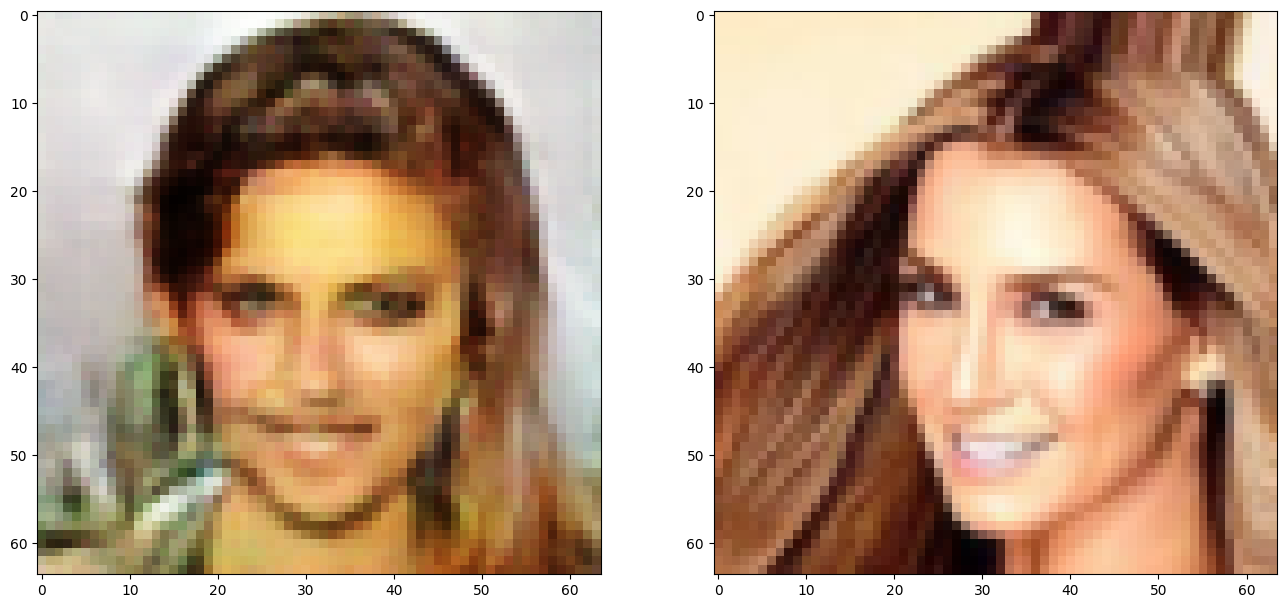

In [125]:
from typing import Optional
vector = (
  torch.tensor(pd.to_numeric(dataframe.loc[0][0:100]).to_numpy(), device=device)
  .unsqueeze(1).unsqueeze(1).unsqueeze(0).float()
)
path = dataframe.loc[0]['img']

real_image = Image.open(f"../resources/datasets/celeba/img_align_celeba/{path}").convert("RGB")
real_image = transform(real_image).unsqueeze(0).to(device)

show_images(generator(vector), real_image)

In [112]:
latent_vector = torch.randn(64, nz, 1, 1, device=device, requires_grad=True)
generated = generator(latent_vector)

show_images(generated)

torch.Size([64, 3, 64, 64])


ValueError: axes don't match array

In [43]:
dataframe.to_csv('latent_vectors.csv')

In [7]:
dataframe = pd.read_csv('latent_vectors.csv')

In [8]:
# Read annotations from celeba dataset
annotations = pd.read_csv('../resources/datasets/celeba/list_attr_celeba.txt', skiprows=1, delim_whitespace=True, index_col=None)
annotations.head()

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
000001.jpg         -1        1              1         -1                 1   
000002.jpg         -1        1             -1         -1                -1   
000003.jpg         -1       -1             -1          1                -1   
000004.jpg         -1       -1              1         -1                 1   
000005.jpg         -1       -1             -1         -1                -1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
000001.jpg           -1                 1                -1               -1   
000002.jpg           -1                -1                -1               -1   
000003.jpg           -1                -1                -1               -1   
000004.jpg           -1                 1                 1               -1   
000005.jpg           -1                 1                -1               -1   

            Young  
000001.jpg      1  
000002.jpg      1  
000003.jpg      1  
000004.jpg      1  
000005.jpg      1  

[5 rows x 40 columns]

In [57]:
# Create classifier for given attributes
class CelebAClassifier(nn.Module):
  def __init__(self, num_attributes):
    super(CelebAClassifier, self).__init__()
    self.num_attributes = num_attributes
    self.layers = nn.Sequential(
      nn.Linear(nz, 512),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(0.1),
      nn.Linear(128, num_attributes),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.layers(input)

classifier = CelebAClassifier(40)
classifier.to(device)

class CelebAClassifierDataset(Dataset):
  def __init__(self, latents_path, annotation_path):
    self.latents_path = latents_path
    self.annotation_path = annotation_path

    self.annotations = pd.read_csv(annotation_path, skiprows=1, delim_whitespace=True, index_col=None)
    self.latents = pd.read_csv(latents_path, index_col=None)

  def __len__(self):
    return len(self.latents)

  def __getitem__(self, idx):
    vector = self.latents.loc[idx][0:100]
    filename = self.latents.loc[idx]['img']
    attributes = self.annotations[self.annotations.index == filename]
    attributes = attributes.replace(-1, 0)
    attributes = attributes.to_numpy().astype(np.float32)
    vector = pd.to_numeric(vector).to_numpy().astype(np.float32)

    return (vector, attributes)


classifier_dataset = CelebAClassifierDataset(
  latents_path='./latent_vectors.csv',
  annotation_path='../resources/datasets/celeba/list_attr_celeba.txt',
)

train_size = int(0.8 * len(classifier_dataset))
val_size = len(classifier_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(classifier_dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=workers)

optimizer = optim.Adam(classifier.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = nn.BCELoss()

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
best_loss = np.inf
best_model = None
epochs_without_improvement = 0
epochs = 200

for epoch in range(1, epochs + 1):
  classifier.train()
  train_loss = 0.0
  for batch_nr, (vectors, attributes) in enumerate(train_dataloader, 1):
    vectors = vectors.to(device)
    attributes = attributes.to(device)

    optimizer.zero_grad()

    output = classifier(vectors).unsqueeze(1)
    loss = criterion(output, attributes)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    train_loss += loss.item()

  train_loss /= len(train_dataloader)

  classifier.eval()
  val_loss = 0.0
  for batch_nr, (vectors, attributes) in enumerate(val_dataloader, 1):
    vectors = vectors.to(device)
    attributes = attributes.to(device)

    output = classifier(vectors).unsqueeze(1)
    loss = criterion(output, attributes)

    val_loss += loss.item()

  val_loss /= len(val_dataloader)

  print(f"Epoch {epoch}/{epochs}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

  if val_loss < best_loss:
    best_loss = val_loss
    best_model = classifier.state_dict()
    epochs_without_improvement = 0
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement == 10:
    print("Early stopping")
    break

Epoch 1/200: Train loss: 0.7002, Val loss: 0.6923
Epoch 2/200: Train loss: 0.6913, Val loss: 0.6859
Epoch 3/200: Train loss: 0.6854, Val loss: 0.6803
Epoch 4/200: Train loss: 0.6756, Val loss: 0.6746
Epoch 5/200: Train loss: 0.6705, Val loss: 0.6688
Epoch 6/200: Train loss: 0.6626, Val loss: 0.6626
Epoch 7/200: Train loss: 0.6537, Val loss: 0.6556
Epoch 8/200: Train loss: 0.6462, Val loss: 0.6479
Epoch 9/200: Train loss: 0.6362, Val loss: 0.6392
Epoch 10/200: Train loss: 0.6237, Val loss: 0.6294
Epoch 11/200: Train loss: 0.6172, Val loss: 0.6189
Epoch 12/200: Train loss: 0.6053, Val loss: 0.6081
Epoch 13/200: Train loss: 0.5923, Val loss: 0.5968
Epoch 14/200: Train loss: 0.5782, Val loss: 0.5852
Epoch 15/200: Train loss: 0.5694, Val loss: 0.5739
Epoch 16/200: Train loss: 0.5590, Val loss: 0.5626
Epoch 17/200: Train loss: 0.5455, Val loss: 0.5515
Epoch 18/200: Train loss: 0.5379, Val loss: 0.5412
Epoch 19/200: Train loss: 0.5258, Val loss: 0.5316
Epoch 20/200: Train loss: 0.5230, Val lo

[0.09694321 0.6198166  0.86998117 0.05671591 0.01387845 0.14669439
 0.25102803 0.07110925 0.16166516 0.06402212 0.07730974 0.434253
 0.03845425 0.03572581 0.01234516 0.02212517 0.01358843 0.01834262
 0.8014723  0.6680729  0.16127919 0.821805   0.00235637 0.10145024
 0.97009295 0.18251963 0.04715981 0.5386329  0.00756757 0.01470642
 0.01834965 0.7878209  0.55823874 0.17434403 0.6348207  0.01336228
 0.6732549  0.04800417 0.03866336 0.9831424 ] [[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1.]]
0: 0.10 - 5_o_Clock_Shadow
1: 0.38 - Arched_Eyebrows
2: 0.13 - Attractive
3: 0.06 - Bags_Under_Eyes
4: 0.01 - Bald
5: 0.15 - Bangs
6: 0.25 - Big_Lips
7: 0.07 - Big_Nose
8: 0.16 - Black_Hair
9: 0.06 - Blond_Hair
10: 0.08 - Blurry
11: 0.57 - Brown_Hair
12: 0.04 - Bushy_Eyebrows
13: 0.04 - Chubby
14: 0.01 - Double_Chin
15: 0.02 - Eyeglasses
16: 0.01 - Goatee
17: 0.02 - Gray_Hair
18: 0.20 - Heavy_Makeup
19: 0.33 - High_Cheekbone

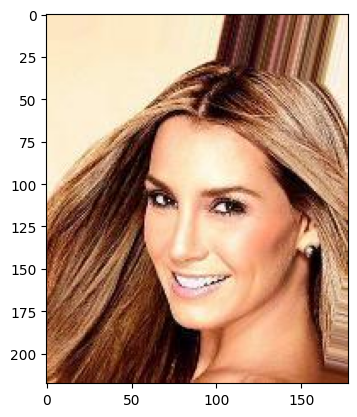

In [58]:
# Test classifier on latent space from the dataset and show real image and predicted attributes

first_vector = torch.tensor(classifier_dataset[0][0]).to(device)
first_image = Image.open(f"../resources/datasets/celeba/img_align_celeba/000001.jpg").convert("RGB")
output = classifier(first_vector).cpu().detach().numpy()
real = classifier_dataset[0][1]

print(output, real)
error = np.abs(output - real)

for idx, err in enumerate(error[0]):
  print(f"{idx}: {err:.2f} - {annotations.columns[idx]}")
  plt.imshow(first_image)
  